In [44]:
import os
import random
from tqdm import tqdm
import numpy as np
import networkx as nx
import matching.glema.common.utils.arg_utils as arg_utils
import matching.glema.common.utils.misc_utils as misc_utils
import matching.glema.common.utils.graph_utils as graph_utils
import matching.glema.common.utils.plot_utils as plot_utils
import matching.glema.data.process.data_generator as generator
import matching.glema.data.process.data_synthesis as synthesis

In [45]:
args = arg_utils.parse_args( use_default=True )
args.dataset = "CPG_augm_large"
args.seed = 42
# args.num_workers = 1
args.split_data = True
args.num_subgraphs = 64
args.directed = False
args.max_subgraph = -1

In [46]:
config_file = os.path.join( args.config_dir, f"{args.dataset}.json" )
config = generator.read_config( config_file )
config

{'number_source': 4880,
 'avg_source_size': 17.286065573770493,
 'std_source_size': 11.022895811050464,
 'avg_degree': 1.9471223120035026,
 'std_degree': 0.4405550933706308,
 'number_label_node': 5,
 'number_label_edge': 1,
 'number_subgraph_per_source': 512}

In [47]:
def node_match( first_node, second_node ):
    return first_node[ "label" ] == second_node[ "label" ]


def edge_match( first_edge, second_edge ):
    return first_edge[ "label" ] == second_edge[ "label" ]

def is_iso( graph, subgraph ):
    graph_matcher = nx.algorithms.isomorphism.GraphMatcher(
        nx.Graph( graph ), nx.Graph( subgraph ), node_match=node_match, edge_match=edge_match
    )
    return graph_matcher.subgraph_is_isomorphic()

In [54]:
def generate_rnd_graph( config, seed, num_labels=3 ):
    misc_utils.set_seed( seed )
    graph = graph_utils.generate_graph( int( config[ "avg_source_size" ] ), directed=True )
    biggest_cluster_size = 0
    biggest_cluster: [ ] = None
    for c in nx.weakly_connected_components( graph ):
        cluster = [ n for n in c ]
        if len( cluster ) > biggest_cluster_size:
            biggest_cluster = cluster
            biggest_cluster_size = len( cluster )
    graph = graph.subgraph( biggest_cluster )
    for n, data in graph.nodes( data=True ):
        data[ "label" ] = random.randint(1, num_labels)
        data[ "anchor" ] = 0
    for s, t, data in graph.edges( data=True ):
        data[ "label" ] = 1
        
    if not args.directed:
        graph = graph.to_undirected()
    anchor = graph_utils.top_pr_ranked_node( graph )
    graph.nodes[ anchor ][ "anchor" ] = 1
    return graph, anchor

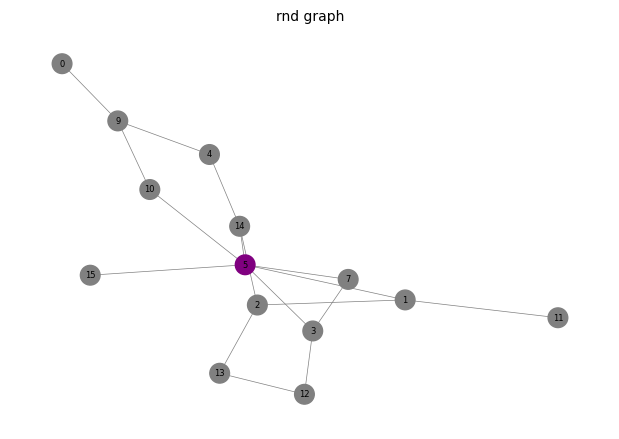

In [55]:
graph, anchor = generate_rnd_graph( config, 16 )
colors = [ "purple" if n == anchor else "grey" for n in graph.nodes() ]
plot_utils.plot_graph( title="rnd graph", graph=graph, nodeColors=colors )

In [59]:
def generate_subgraph_iso( graph, anchor, num, config ):
    subgraphs = [ ]
    for i in range( num ):
        misc_utils.set_seed( i )
        no_of_nodes = np.random.randint( 2, graph.number_of_nodes() + 1 )
        subgraph = generator.generate_iso_subgraph(
            nx.Graph( graph ),
            anchor,
            True,
            no_of_nodes,
            **config
        )
        subgraphs.append( subgraph )
    return subgraphs

Is isomorph: True


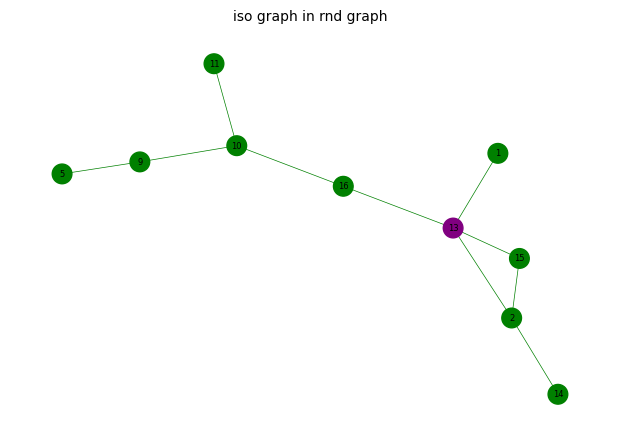

In [60]:
num_subgraphs = 23
iso_subgraphs = generate_subgraph_iso( graph, anchor, num_subgraphs, config )
iso_subgraph = iso_subgraphs[ num_subgraphs - 1 ]
print( f"Is isomorph: {is_iso( graph, iso_subgraph )}" )

matching_colors = {
    2: "purple",
    1: "green",
    0: "grey",
    -1: "red"
}
combined_iso, node_colors, edge_colors = graph_utils.combine_graph(
    graph.to_undirected(), iso_subgraph, anchor=anchor, matching_colors=matching_colors )

plot_utils.plot_graph(
    title="iso graph in rnd graph",
    graph=combined_iso,
    nodeColors=node_colors,
    edgeColors=edge_colors )

In [61]:
anchor_iso_subgraphs = 0
iso_iso_subgraphs = 0
total_iso_subgraphs = 0
non_iso_example = None
for seed in tqdm( range( 100 ) ):
    graph, anchor = generate_rnd_graph( config, seed )
    subgraphs = generate_subgraph_iso( graph, anchor, 20, config )
    for subgraph in subgraphs:
        if anchor in subgraph.nodes:
            anchor_iso_subgraphs += 1
        if is_iso( graph, subgraph ):
            iso_iso_subgraphs += 1
        else:
            non_iso_example = (graph, subgraph)
        total_iso_subgraphs += 1

print( f"Found anchors in iso subgraphs: {anchor_iso_subgraphs}/{total_iso_subgraphs}" )
print( f"Found isomorph graphs in iso subgraphs: {iso_iso_subgraphs}/{total_iso_subgraphs}" )
if non_iso_example is not None:
    graph, subgraph = non_iso_example
    plot_utils.plot_graph( graph, title="graph", 
                           nodeLabels=graph_utils.get_node_labels( graph ),
                           nodeColors=graph_utils.get_node_colors(graph) )
    plot_utils.plot_graph( subgraph, title="subgraph", 
                           nodeLabels=graph_utils.get_node_labels( subgraph ),
                           nodeColors=graph_utils.get_node_colors(subgraph) )

100%|██████████| 100/100 [00:01<00:00, 56.91it/s]

Found anchors in iso subgraphs: 2000/2000
Found isomorph graphs in iso subgraphs: 2000/2000


In [62]:
def generate_subgraph_noniso( graph, anchor, num, config ):
    subgraphs = [ ]
    for i in range( num ):
        misc_utils.set_seed( i )
        no_of_nodes = np.random.randint( 2, graph.number_of_nodes() + 1 )
        subgraph = generator.generate_noniso_subgraph(
            nx.Graph( graph ),
            anchor,
            True,
            no_of_nodes,
            **config
        )
        subgraphs.append( subgraph )
    return subgraphs

Is isomorph: False


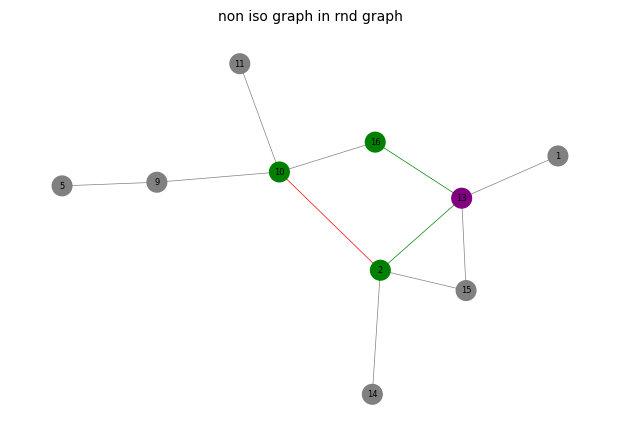

In [63]:
num_subgraphs = 14
noniso_subgraphs = generate_subgraph_noniso( graph, anchor, num_subgraphs, config )
noniso_subgraph = noniso_subgraphs[ num_subgraphs - 1 ]
print( f"Is isomorph: {is_iso( graph, noniso_subgraph )}" )

matching_colors = {
    2: "purple",
    1: "green",
    0: "grey",
    -1: "red"
}
combined_noniso, node_colors, edge_colors = graph_utils.combine_graph(
    graph.to_undirected(), noniso_subgraph, anchor=anchor, matching_colors=matching_colors )

plot_utils.plot_graph(
    title="non iso graph in rnd graph",
    graph=combined_noniso,
    nodeColors=node_colors,
    edgeColors=edge_colors )

In [64]:
anchor_noniso_subgraphs = 0
iso_noniso_subgraphs = 0
total_noniso_subgraphs = 0
skipped_subgraphs = 0
for seed in tqdm( range( 100 ) ):
    graph, anchor = generate_rnd_graph( config, seed )
    #colors = [ "purple" if n == anchor else "grey" for n in graph.nodes() ]
    #plot_utils.plot_graph( title=f"#{seed}", graph=graph, nodeColors=colors )
    
    subgraphs = generate_subgraph_noniso( graph, anchor, 20, config )
    for subgraph in subgraphs:
        if subgraph == None:
            skipped_subgraphs += 1
            continue
        if anchor in subgraph.nodes:
            anchor_noniso_subgraphs += 1
        if is_iso( graph, subgraph ):
            iso_noniso_subgraphs += 1
        total_noniso_subgraphs += 1

print( f"Skipped generation of subgraphs: {skipped_subgraphs}" )
print( f"Found anchors in non iso subgraphs: {anchor_noniso_subgraphs}/{total_noniso_subgraphs}" )
print( f"Found isomorph graphs in non iso subgraphs: {iso_noniso_subgraphs}/{total_noniso_subgraphs}" )

100%|██████████| 100/100 [00:03<00:00, 31.45it/s]

Skipped generation of subgraphs: 42
Found anchors in non iso subgraphs: 1484/1958
Found isomorph graphs in non iso subgraphs: 0/1958
